## Weather effect on cyclists
This pipeline takes weather data from a weatherstation in Münster and compares to the amount of cyclists that traveled through "josefsviertel" in Münster.

## Install dependencies
Install all requiered libraries for the following code

In [25]:
%pip install pandas
%pip install 'SQLAlchemy==1.4.46'
%pip install -U matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Load and write Cyclist Data
Create a pandas dataframe for every month of the year 2019. The data is collected from csv files which are uploaded on github. After each loading sequence the dataframe is written to a sqlite table. Since each month is in a seperate csv file, twelve tables are created.

In [26]:
import pandas as pd

for i in range(1,13):
        num = str(i)
        if len(num) == 1:
            num = "0"+num    
        df = pd.read_csv("https://raw.githubusercontent.com/od-ms/radverkehr-zaehlstellen/main/100031297/2019-"+num+".csv")

        df.to_sql("Monthdata"+num,'sqlite:///data.sqlite',if_exists="replace")


## Load and write Weather Data
The weather data is read form a local text file. This is due to the fact that it is only accesable through a zip folder online. 

In [27]:
df = pd.read_csv("/home/wicket/Downloads/stundenwerte_TF_01766_19891001_20221231_hist/produkt_tf_stunde_19891001_20221231_01766.txt",sep=";")

df.to_sql("weather",'sqlite:///data.sqlite',if_exists="replace")

290701

## Loading data and processing
Once the data is stored into a sql table, it is loaded into panda data frames again for further processing.

In this case the monthly cyclist data is stored into an array which only contains the date as a datetime object and the counted amount of cyclists.

In [28]:
from datetime import datetime
monthdata = []
for i in range(1, 13):
    num = str(i)
    if len(num) == 1:
        num = "0"+num

    df = pd.read_sql_table('Monthdata'+num, 'sqlite:///data.sqlite')
    for index, row in df.iterrows():
        monthdata.append((datetime.strptime(
            row["Datetime"], "%Y-%m-%d %H:%M"), row["100031297 (Promenade)"]))


Here the weather data loaded and trimmed to only contain the year 2019 since this is the year we will be looking at. This is done using the `valdate` function.
Once the data is trimmed it is also loaded into anarray which only contains the date as a datetime object and the air humidity.


In [29]:
def valdate(input):
    if input < 2019000000 or input >= 2020000000:
        return False
    return True

In [30]:
weatherdata = []
df = pd.read_sql_table('weather', 'sqlite:///data.sqlite')
df = df[df["MESS_DATUM"].apply(lambda x: valdate(x))]
for index, row in df.iterrows():
    weatherdata.append(
        (datetime.strptime(str(row["MESS_DATUM"]), "%Y%m%d%H"), row["RF_STD"]))


The final step  in order to be able to compare the weather data with the cyclist data is to create equals data steps. In this case the cyclist data is noted in a 15 min step size while the weather data is not with a stepsize of 1 hour. The following code adds the amount of cyclists per hour.

In [31]:
currdate = monthdata[0][0]
combinedmonth = []
sum = 0
for i in monthdata:
    if i[0].hour == currdate.hour:
        sum = sum + i[1]
    else:
        combinedmonth.append((currdate, sum))
        sum = i[1]
        currdate = i[0]


## Analysis of results
In order to visually see the effect of humidity in the air and the amount of cyclists we will only look at a month worth of data since the plot gets to concested with data over one year.

As can be seen by the plot below, the humidity in % is obviously not an ideal measure for how good or bad the weather actually is. Unfortunately I was unable to find data of for example rain per square meter. When looking at the plot however one can still see a correlation between humidity and the amount of cyclists. This being said, the main factor for the cyclists is still the time of day.


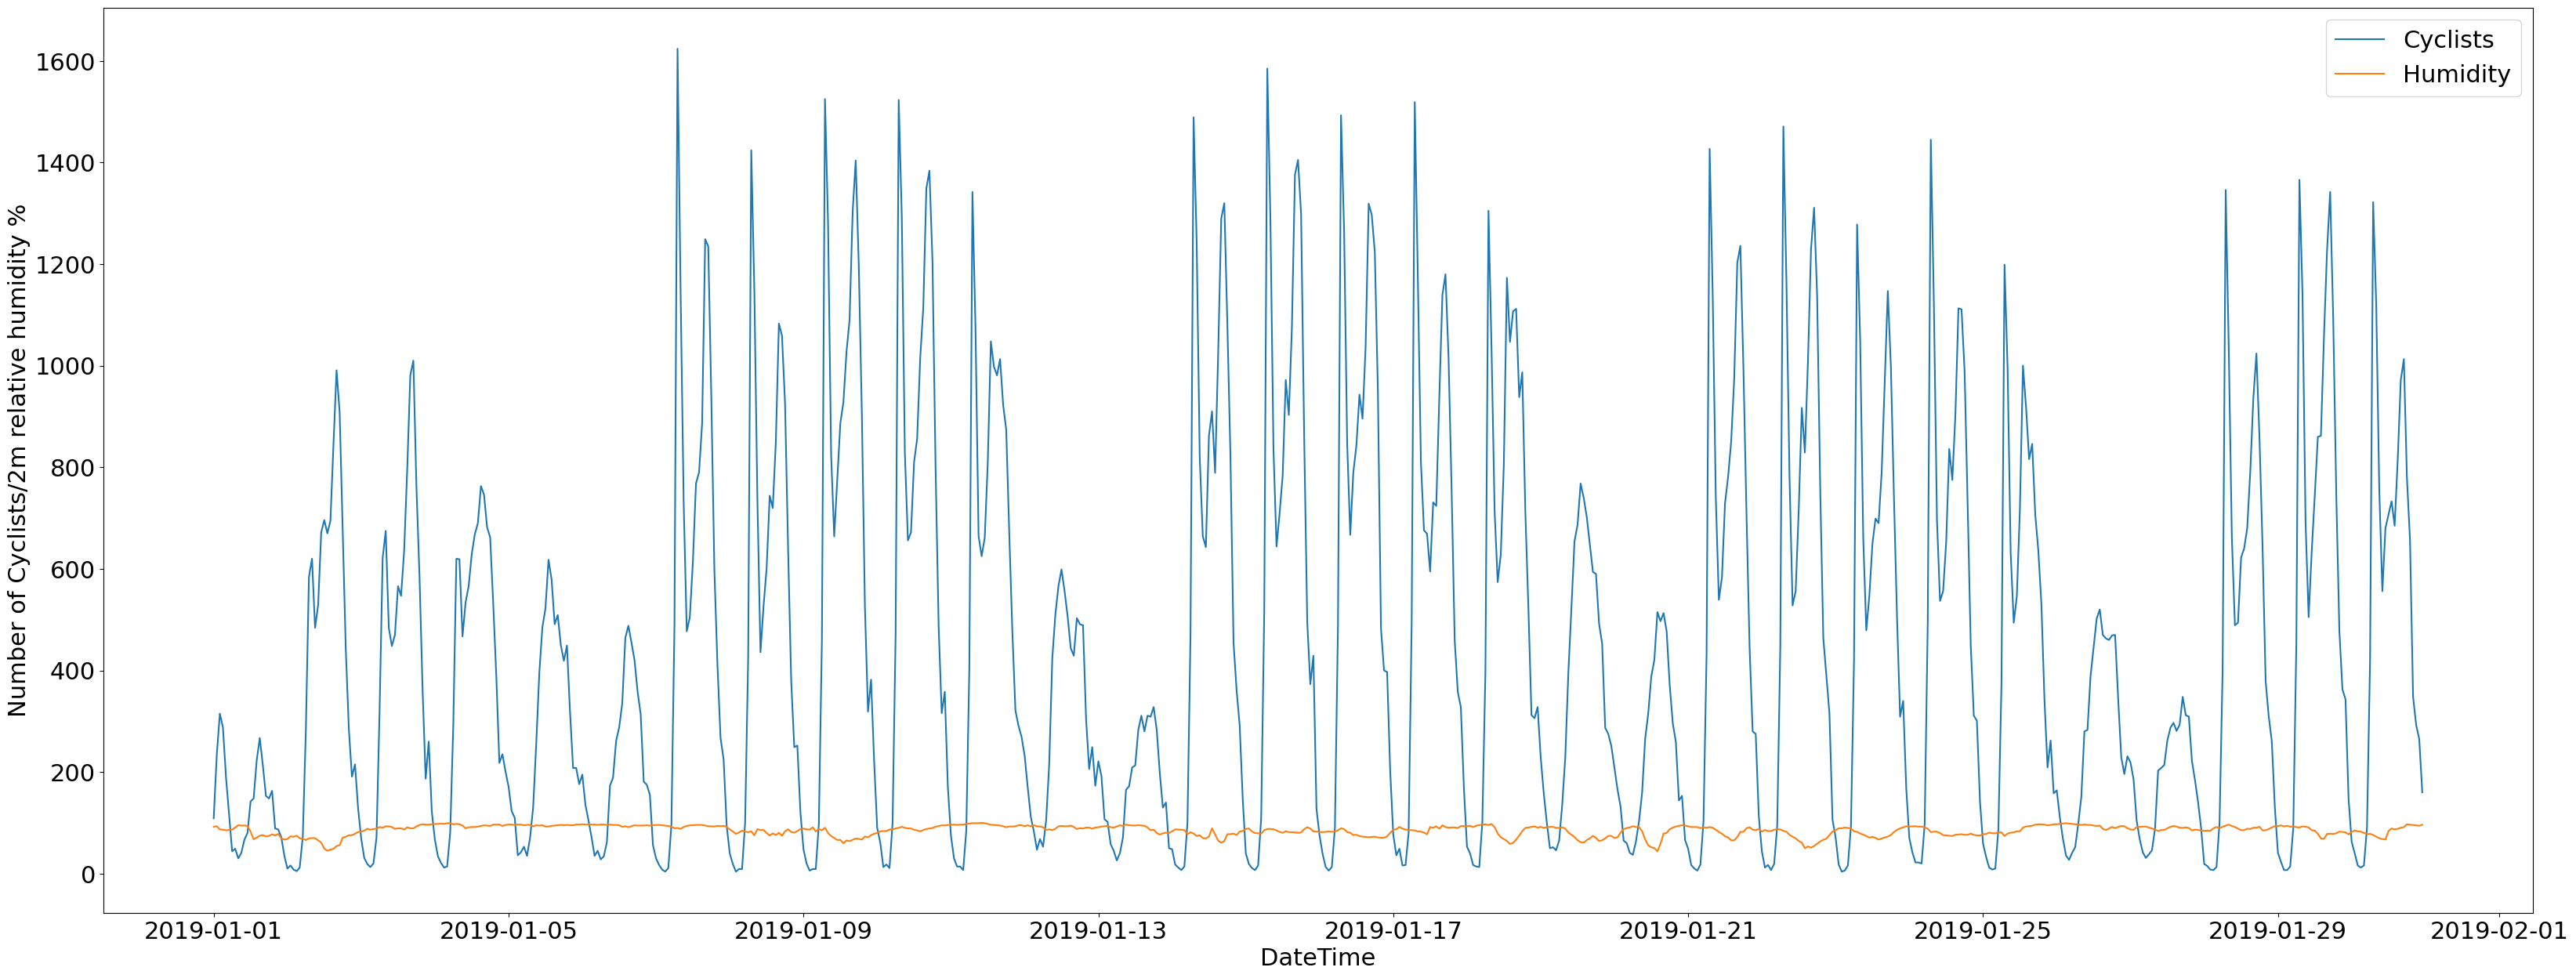

In [34]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (40,15)
plt.rcParams.update({'font.size': 22})
zip(*combinedmonth)
plt.plot(*zip(*combinedmonth[0:720]), label="Cyclists")
zip(*weatherdata)
plt.plot(*zip(*weatherdata[0:720]), label="Humidity")

plt.xlabel('DateTime', fontsize=22)
plt.ylabel('Number of Cyclists/2m relative humidity %', fontsize=22)
plt.legend(loc="upper right")
plt.show()
